In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import math
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix
import csv

In [2]:
Error_lot_list = pd.read_csv(
    "D:\\Dataset\\#1_Dataset_장비이상 조기탐지 AI 데이터셋#1\\data\\5공정_180sec\\Error Lot list.csv",header=None,
    names=["0","1","2","3","4","5","6","7","8","9","10","11"]
)

date_load = Error_lot_list["0"][1:]
date_list = date_load.values

formatted_date_list = []

for date_str in date_list:
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    formatted_date = date_obj.strftime('%Y.%m.%d')
    formatted_date_list.append(formatted_date)

print(formatted_date_list)


['2021.09.06', '2021.09.07', '2021.09.08', '2021.09.09', '2021.09.10', '2021.09.13', '2021.09.14', '2021.09.15', '2021.09.16', '2021.09.17', '2021.09.23', '2021.09.24', '2021.09.27', '2021.09.28', '2021.09.29', '2021.09.30', '2021.10.01', '2021.10.05', '2021.10.06', '2021.10.07', '2021.10.08', '2021.10.12', '2021.10.13', '2021.10.14', '2021.10.15', '2021.10.18', '2021.10.19', '2021.10.20', '2021.10.21', '2021.10.22', '2021.10.25', '2021.10.26', '2021.10.27']


In [3]:
data = []

for date in formatted_date_list:
    csv_path = f"D:\\Dataset\\#1_Dataset_장비이상 조기탐지 AI 데이터셋#1\\data\\5공정_180sec\\kemp-abh-sensor-{date}.csv"
    df = pd.read_csv(csv_path)
    sc = df[['Temp','Current']].astype(float)
    data.append(sc)
x_label_df = pd.concat(data, axis=0,ignore_index=True)
x_label_df['Temp/Current'] = x_label_df['Temp'] / x_label_df['Current']
x_label_df = x_label_df.drop(columns=['Temp','Current'])

# 33(날짜)X43(Process)X36(Index) => 51084
print(x_label_df)


       Temp/Current
0         46.670275
1         50.104851
2         45.371934
3         44.116610
4         44.552119
...             ...
51079     43.149022
51080     44.520152
51081     43.821683
51082     45.883469
51083     45.316010

[51084 rows x 1 columns]


In [4]:
y_label=[]

for index, row in Error_lot_list.iloc[1:].iterrows():
    df = row.to_list()
    df_value = df[1:]
    for i in range(1,44):
        if i in df_value: 
            for j in range(1,37):
                y_label.append(1)
        else:
            for j in range(1,37): 
                y_label.append(0)
                
y_label_array = np.array(y_label).reshape(-1, 1)
y_label_df = pd.DataFrame(y_label_array, columns=['Y'])
print("y_label_df")
print(y_label_df)

y_label_df
       Y
0      0
1      0
2      0
3      0
4      0
...   ..
51079  0
51080  0
51081  0
51082  0
51083  0

[51084 rows x 1 columns]


In [5]:
sample_count = 3960

dataset = tf.data.Dataset.from_tensor_slices((x_label_df, y_label_df))

# y_label_df가 1인 샘플 추출
positive_samples = dataset.filter(lambda x, y: tf.math.equal(y[0], 0)).take(sample_count)

# y_label_df가 0인 샘플 추출
negative_samples = dataset.filter(lambda x, y: tf.math.equal(y[0], 1)).take(sample_count)

positive_samples = positive_samples.shuffle(buffer_size=sample_count, seed=42)
negative_samples = negative_samples.shuffle(buffer_size=sample_count, seed=42)

train_ratio = 0.6  
valid_ratio = 0.2
test_ratio = 0.2  

# 데이터셋을 분할
num_samples = 2*sample_count
train_size = int(train_ratio * num_samples)
valid_size = int(valid_ratio * num_samples)
test_size = int(test_ratio*num_samples)


positive_train_samples = positive_samples.take(train_size // 2)
negative_train_samples = negative_samples.take(train_size // 2)
train_dataset = positive_train_samples.concatenate(negative_train_samples)

positive_temp_samples = positive_samples.skip(train_size // 2)
negative_temp_samples = negative_samples.skip(train_size // 2)

positive_valid_samples = positive_temp_samples.take(valid_size // 2)
negative_valid_samples = negative_temp_samples.take(valid_size // 2)
valid_dataset = positive_valid_samples.concatenate(negative_valid_samples)

positive_test_samples = positive_temp_samples.skip(test_size // 2)
negative_test_samples = negative_temp_samples.skip(test_size // 2)
test_dataset = positive_test_samples.concatenate(negative_test_samples)



In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_label_df.shape[1],))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 데이터셋 배치 설정
train_dataset = train_dataset.batch(16)
valid_dataset = valid_dataset.batch(16)

history = model.fit(train_dataset, epochs=150, validation_data=valid_dataset)
model.save("model.h5")

Epoch 1/150
297/297 [==============================] - 4s 11ms/step - loss: 43.0274 - accuracy: 0.5000 - val_loss: 36.5564 - val_accuracy: 0.5000
Epoch 2/150
297/297 [==============================] - 2s 7ms/step - loss: 30.4363 - accuracy: 0.5000 - val_loss: 24.7579 - val_accuracy: 0.5000
Epoch 3/150
297/297 [==============================] - 2s 6ms/step - loss: 18.6687 - accuracy: 0.5000 - val_loss: 13.0565 - val_accuracy: 0.5000
Epoch 4/150
297/297 [==============================] - 2s 6ms/step - loss: 7.1785 - accuracy: 0.5000 - val_loss: 1.7760 - val_accuracy: 0.5000
Epoch 5/150
297/297 [==============================] - 2s 6ms/step - loss: 0.6208 - accuracy: 0.8594 - val_loss: 1.0083 - val_accuracy: 0.5000
Epoch 6/150
297/297 [==============================] - 2s 7ms/step - loss: 0.7521 - accuracy: 0.5928 - val_loss: 1.0278 - val_accuracy: 0.5000
Epoch 7/150
297/297 [==============================] - 2s 6ms/step - loss: 0.7341 - accuracy: 0.6210 - val_loss: 1.0311 - val_accuracy:

99/99 [==============================] - 1s 9ms/step - loss: 0.0715 - accuracy: 1.0000


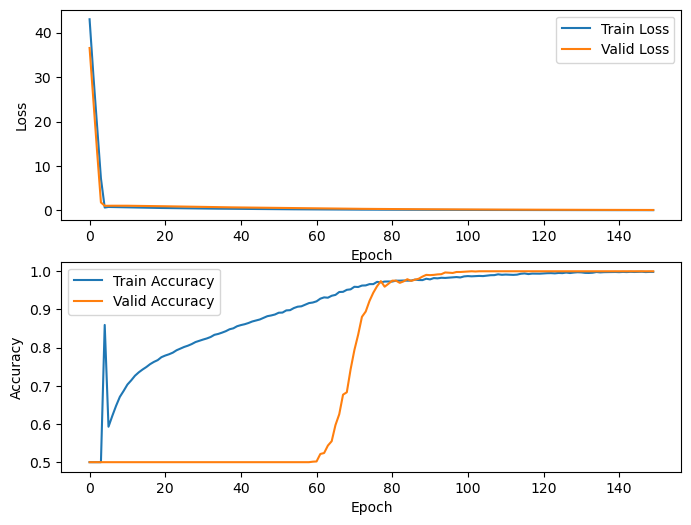

Test Loss: 0.07153303176164627
Test Accuracy: 1.0


In [7]:
test_dataset = test_dataset.batch(16) 
test_loss, test_accuracy = model.evaluate(test_dataset)

plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


99/99 [==============================] - 1s 8ms/step


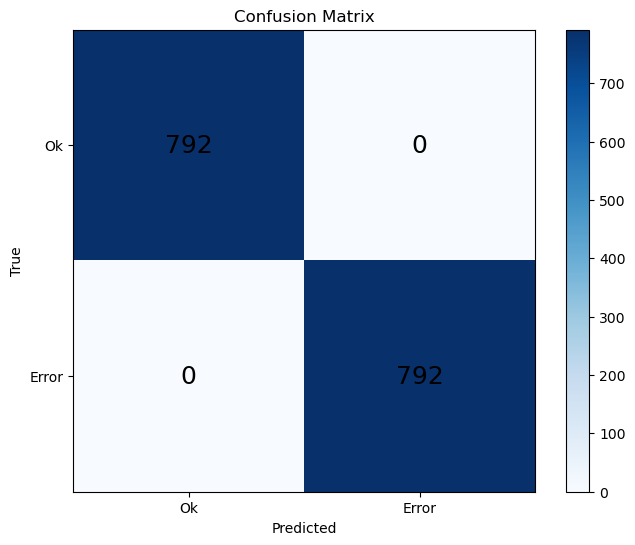

In [8]:

test_loss, test_accuracy = model.evaluate(test_dataset)
y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)  # 0.5를 기준으로 이진화

# 실제 레이블
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

confusion = confusion_matrix(y_true, y_pred)

class_names = ['Ok', 'Error']

plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color='black', fontsize=18)

plt.show()

99/99 [==============================] - 1s 8ms/step
acc
1.0
sen
1.0
spe
1.0
prc
1.0
Confusion Matrix:
[[1. 0.]
 [0. 1.]]


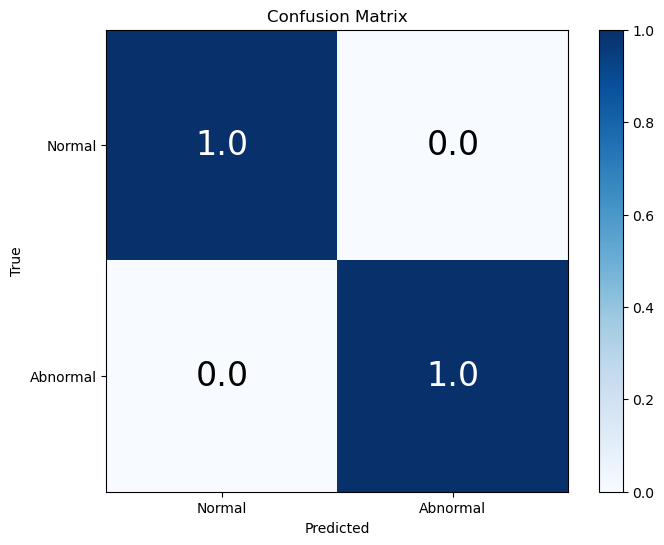

In [9]:

test_loss, test_accuracy = model.evaluate(test_dataset)
y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5)  

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Normal -> 0 Abnormal -> 1
true_positive = np.sum(np.logical_and(y_true == 0, y_pred == 0))
true_negative = np.sum(np.logical_and(y_true == 1, y_pred == 1))
false_positive = np.sum(np.logical_and(y_true == 1, y_pred == 0))
false_negative = np.sum(np.logical_and(y_true == 0, y_pred == 1))

total_positive = true_positive+false_negative
total_negative = true_negative+false_positive

print("acc")
print(round((true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative),4))
print("sen")
print(round(true_positive/(true_positive+false_negative),4))
print("spe")
print(round(true_negative/(true_negative+false_positive),4))
print("prc")
print(round(true_positive/(true_positive+false_positive),4))
 

confusion_matrix = np.array([[round(true_positive/total_positive,4), round(false_positive/total_negative,4)],
                             [round(false_negative/total_positive,4), round(true_negative/total_negative,4)]])

print("Confusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Abnormal'])
plt.yticks([0, 1], ['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.text(0, 0, str(confusion_matrix[0, 0]), ha='center', va='center', color='white', fontsize=24)
plt.text(1, 0, str(confusion_matrix[0, 1]), ha='center', va='center', color='black', fontsize=24)
plt.text(0, 1, str(confusion_matrix[1, 0]), ha='center', va='center', color='black', fontsize=24)
plt.text(1, 1, str(confusion_matrix[1, 1]), ha='center', va='center', color='white', fontsize=24)
plt.show()

In [10]:
#Tensorflow Lite로 변환
#양자화없이 Lite로 변환 
#converter = tf.lite.TFLiteConverter.from_keras_model(model_1) 
#tflite_model = converter.convert() 
#open("sine_model.tflite", "wb").write(tflite_model) 
#양자화해서 Lite로 변환 
# converter = tf.lite.TFLiteConverter.from_keras_model(model_2) 
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] 
# tflite_model = converter.convert() 
# open("sine_model_quantized.tflite", "wb").write(tflite_model)

In [11]:
new_data = np.array([[35,45,55,65,76,89,101,122]])

for data in new_data : 
    predictions = model.predict(data)

pred = []

for p in predictions :
    if p>0.5 : 
        pred.append(['Error'])
    else:
        pred.append(['Ok'])

for i in range (0,8):
    print("new_data : ", new_data[0][i])
    print("pred_value : ",predictions[i])
    print("pred_class : ",pred[i])
    print("--------------------------------------------------------------------")

1/1 [==============================] - 0s 38ms/step
new_data :  35
pred_value :  [0.03754259]
pred_class :  ['Ok']
--------------------------------------------------------------------
new_data :  45
pred_value :  [0.14257972]
pred_class :  ['Ok']
--------------------------------------------------------------------
new_data :  55
pred_value :  [0.41482836]
pred_class :  ['Ok']
--------------------------------------------------------------------
new_data :  65
pred_value :  [0.7513727]
pred_class :  ['Error']
--------------------------------------------------------------------
new_data :  76
pred_value :  [0.93708163]
pred_class :  ['Error']
--------------------------------------------------------------------
new_data :  89
pred_value :  [0.98990846]
pred_class :  ['Error']
--------------------------------------------------------------------
new_data :  101
pred_value :  [0.9982138]
pred_class :  ['Error']
--------------------------------------------------------------------
new_data :  1